# Linear GP System in Python
## By: Nathan Haut

### Implementation Notes

This implementation evolves models of the form model = [node, node, node] where each node = [active?, operator, var/const1, var/const2].

The default operators are protected division, addition, subtraction, and multiplication. More operators can easily be added by adding them to the ops list. 

I've implemented two different evolution variants. One that uses standard tournament selection and another that uses Pareto tournament selection. The tournament selection method uses just correlation as its fitness function. The Pareto tournament selection uses both correlation and model complexity as fitness metrics. The approach using Pareto tournament selection had to be modified to expect possibly multiple models be returned by each tournament rather than only one ever being returned. 

Both evolution functions expect 2 inputs and allow for several optional inputs. The required inputs are the input data and response data. The optional inputs are generations, crossover rate, mutation rate, population size, and plotting. The default parameters are:
 
| Option | Default Settings |
| --- | --- |
| Generations | 100 |
| Crossover Rate | 0.1 |
| Mutation Rate | 0.9 | 
| Population Size | 300 |
| Plot | True |

Correlation was used as the fitness measure since it shrinks the search space significantly and speeds up the search process when compared to RMSE which is commonly used. The only drawback of using correlation is that models must be aligned before they are usable outside of the evolution. The alignment parameters can be determined using the **alignModel** function. The model can then be correctly run with the alignment parameters using the **alignedEvalProg** function. 

The **recombination** function uses 3 types of recombination: element swap, node spaw, and 1 point crossover. 

The **mutate** function utilizes element mutation and node mutation. The element mutation will change either the activation, operator, or variable/constant. The node mutation will change a node to a new randomly generated node. 

In [50]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math
import copy
from scipy.stats import pearsonr # for computing correlation
from functools import reduce #for flattening lists
from operator import concat  #for flattening lists
data=np.linspace(0,2*math.pi,50)
response=np.sin(data)
def protectDiv(a,b):
    
    if (type(b)==int or type(b)==float or type(b)==np.float64) and b==0:
        return a/1
    if (type(b)==np.ndarray) and (0 in b):
        return a/np.where(b==0,1,b)
    return a/b
def add(a,b):
    return a+b
def sub(a,b):
    return a-b
def mult(a,b):
    return a*b
# def sine(a,b):
#     return np.sin(a)
ops=[protectDiv,add,sub,mult]#,sine]
def randomProg(): # generate random linear program
    prog=[]
    # [Activation Pos (0,1), Operator Pos, Var/Const1, Var/Const2]
    prog.append([random.randrange(0,2,1),random.randrange(0,4,1),random.randrange(0,6,1),random.randrange(0,6,1)])
    while random.randrange(0,10,1)<=8:
        prog.append([random.randrange(0,2,1),random.randrange(0,4,1),random.randrange(0,6,1),random.randrange(0,6,1)])
    return prog

def evalProg(prog,data): # Interpreter
        tmp=0
        ops=[protectDiv,add,sub,mult]#,sine] #np.sin
        varConst=[data,-2,-1,1,2]
        for i in prog:
            if i[0]==1: #if code line is active
                if i[2]==5 and i[3]<5:
                    tmp=ops[i[1]](tmp,varConst[i[3]])
                elif i[3]==5 and i[2]<5:
                    tmp=ops[i[1]](varConst[i[2]],tmp)
                elif i[3]==5 and i[2]==5:
                    tmp = ops[i[1]](tmp,tmp)
                else:
                    tmp = ops[i[1]](varConst[i[2]],varConst[i[3]])
            #print(tmp)
        if type(tmp)==float or type(tmp)==int:
            tmp=np.full(len(data),tmp)
        return tmp
            
def fitness(prog,data,response): # Fitness function using correlation
    fit=1-pearsonr(evalProg(prog,data),response)[0]**2  # 1-R^2
    if math.isnan(fit):
        return 1 # If nan return 1 as fitness
    return fit   # Else return actual fitness 1-R^2

def mseFit(prog,data,response): # Fitness function using MSE
    return np.mean((evalProg(prog,data)-response)**2)
    
def mutate(prog,varConst): # Mutation function
    mutantProg=copy.deepcopy(prog)
    nodeOrPart=random.randrange(0,2,1)
    node=random.randrange(0,len(prog))
    pos=random.randrange(0,len(prog[node]))
    if nodeOrPart==0:
        if pos==0:
            mutantProg[node][pos]=random.randrange(0,2,1) # Change activation
        elif pos==1:
            mutantProg[node][pos]=random.randrange(0,len(ops),1) # Change operator
        else:
            mutantProg[node][pos]=random.randrange(0,len(varConst)+1,1) # Change var/const
    else:
        mutantProg[node]=randomProg()[0].copy() # Change node
    return mutantProg

def recombination(prog1,prog2): # Recombination function
    receivingParent=random.randrange(0,2,1)
    donorParent=1-receivingParent
    newProg=copy.deepcopy([prog1,prog2][receivingParent])
    donor=copy.deepcopy([prog1,prog2][donorParent])
    nodeOrInstruction=random.randrange(0,3,1)
    node1=random.randrange(0,len(newProg),1)
    node2=random.randrange(0,len(donor),1)
    part=random.randrange(0,4,1)
    if nodeOrInstruction==0: #Node swap
        newProg[node1]=donor[node2].copy()
    elif nodeOrInstruction==1: #Element swap
        newProg[node1][part]=donor[node2][part]
    else:                      # 1 Pt Crossover
        newProg[node1:]=copy.deepcopy(donor[node2:])
    return newProg

def tournamentSelect(pop,data,response):
    fitnesses=[fitness(i,data,response) for i in pop]
    bestLoc=np.argmin(fitnesses)
    winner=copy.deepcopy(pop[bestLoc])
    return winner

def evolve(data,response,generations=100,px=0.1,pm=0.9,popSize=300,plot=True): # evolution using standard tournament selection
    population=[randomProg() for i in range(popSize)]
    fitness_list=[]
    pop=copy.deepcopy(population)
    for i in range(generations):
        mutateIndividuals=[mutate(tournamentSelect(random.sample(pop,2),data,response),[data,-2,-1,1,2]) for i in range(int(pm*popSize))]
        crossoverIndividuals=[recombination(tournamentSelect(random.sample(pop,2),data,response),tournamentSelect(random.sample(pop,2),data,response)) for i in range(int(px*popSize))]
        best=copy.deepcopy(tournamentSelect(pop,data,response))
        pop=[]
        [pop.append(copy.deepcopy(i)) for i in mutateIndividuals]
        [pop.append(copy.deepcopy(i)) for i in crossoverIndividuals]
        pop.append(best)
        fitness_list.append(fitness(best,data,response))
    best=tournamentSelect(pop,data,response)
    if plot:
        plt.yscale("log")
        plt.plot(fitness_list)
        plt.show()
    return best, pop

def paretoTournament(pop,data,response): # selects the Pareto front of a model set
    pFront=[]
    fitnesses=np.array([fitness(i,data,response) for i in pop])
    complexities=np.array([len(i) for i in pop])
    fitSort=np.argsort(fitnesses)
    cSort=np.argsort(complexities)
    popFitSort=np.array(pop,dtype=object)[fitSort]
    popCSort=np.array(pop,dtype=object)[cSort]
    popFitCArgs=np.argsort([len(i) for i in popFitSort])
    i=0
    while len(popCSort)>0:
        if popFitCArgs[i]<len(popCSort):
            pFront.append(copy.deepcopy(popFitSort.tolist()[i]))
            popCSort=np.array(popCSort)[:popFitCArgs[i]]
        i+=1
    return pFront

def paretoEvolve(data,response,generations=100,px=0.1,pm=0.9,popSize=300,plot=True): # evolution using Pareto tournaments
    population=[randomProg() for i in range(popSize)]
    fitness_list=[]
    pop=copy.deepcopy(population)
    for i in range(generations):
        toMutate=reduce(concat,[paretoTournament(random.sample(pop,5),data,response) for i in range(int(pm*popSize))])
        mutateIndividuals=[mutate(random.sample(toMutate,1)[0],[data,-2,-1,1,2]) for i in range(int(pm*popSize))]
        toCross=reduce(concat,[paretoTournament(random.sample(pop,5),data,response) for i in range(int(px*popSize))])
        crossoverIndividuals=[recombination(random.sample(toCross,1)[0],random.sample(toCross,1)[0]) for i in range(int(px*popSize))]
        best=copy.deepcopy(paretoTournament(pop,data,response))
        pop=[]
        [pop.append(copy.deepcopy(i)) for i in mutateIndividuals]
        [pop.append(copy.deepcopy(i)) for i in crossoverIndividuals]
        [pop.append(copy.deepcopy(i)) for i in best]
        fitness_list.append(fitness(best[0],data,response))
    best=tournamentSelect(pop,data,response)
    #align=np.polyfit(evalProg(best,data),response,1)
    #best.append([1,3,5,align[0]])
    #best.append([1,1,5,align[1]])
    if plot:
        plt.yscale("log")
        plt.plot(fitness_list)
        plt.show()
    return best, pop

def alignModel(model, data, response): # computes alignment parameters for a model
    align=np.polyfit(evalProg(best,data),response,1)
    return align
    
def alignedEvalProg(model, data, alignment): # applies the alignment parameters to model evalution
    return alignment[0]*evalProg(model,data)+alignment[1]

# Examples

## Evolve using standard tournament selection

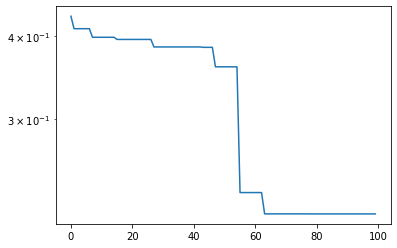

In [51]:
best,pop=evolve(data,response)

In [52]:
print(fitness(best,data,response))

0.2153192007133783


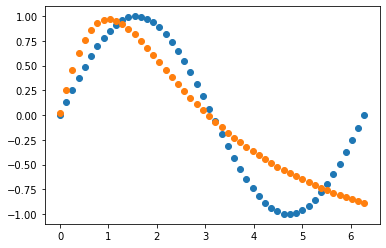

In [53]:
align=alignModel(best,data,response)
plt.scatter(data,response)
plt.scatter(data,alignedEvalProg(best,data,align))

## Evolve using Pareto tournaments

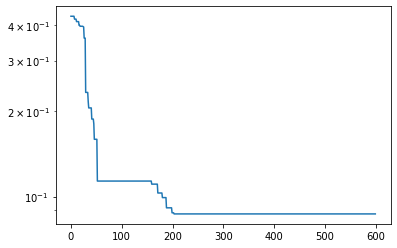

0.08694387923789137


In [36]:
best,pop=paretoEvolve(data,response,generations=600)
print(fitness(best,data,response))

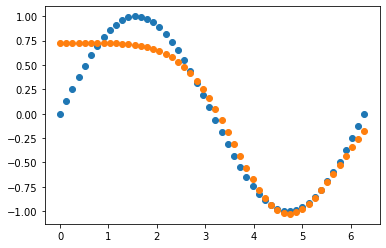

In [37]:
align=alignModel(best,data,response)
plt.scatter(data,response)
plt.scatter(data,alignedEvalProg(best,data,align))

In [38]:
len(best)

643

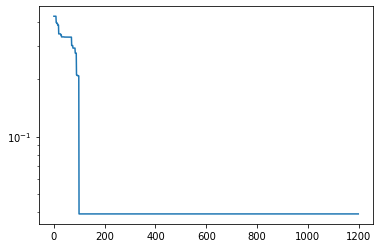

0.03918306124265747


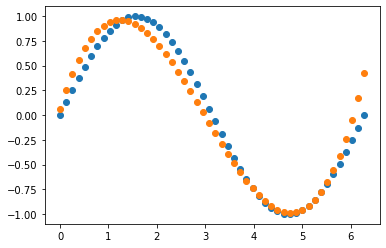

In [39]:
best,pop=paretoEvolve(data,response,generations=1200)
print(fitness(best,data,response))
align=alignModel(best,data,response)
plt.scatter(data,response)
plt.scatter(data,alignedEvalProg(best,data,align))

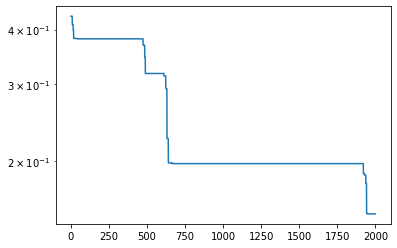

0.1512887072650766


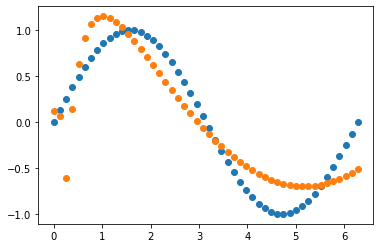

In [54]:
best,pop=paretoEvolve(data,response,generations=2000)
print(fitness(best,data,response))
align=alignModel(best,data,response)
plt.scatter(data,response)
plt.scatter(data,alignedEvalProg(best,data,align))